## Group 9 Coursework

#### Importing Data

In [72]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz as gp
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from datetime import date
import plotly.graph_objects as go
import plotly.express as px
import math

#### Data preprocessing

In [73]:
# load data 
claims = pd.read_csv("Insurance_claims.csv")
claims.head(2)

,ReferenceId,PolicyholderNumber,FirstPartyVehicleNumber,ThirdPartyVehicleNumber,InsurerNotes,PolicyholderOccupation,LossDate,FirstPolicySubscriptionDate,ClaimCause,ClaimInvolvedCovers,...,NumberOfPoliciesOfPolicyholder,FpVehicleAgeMonths,EasinessToStage,ClaimWihoutIdentifiedThirdParty,ClaimAmount,LossHour,PolicyHolderAge,NumberOfBodilyInjuries,FirstPartyLiability,Fraud
0,4842,531112,715507.0,NaN,avoids a cat and hits a garage pole With deduc...,CivilServant,1/2/19,6/18/18,CollisionWithAnimal,MaterialDamages ActLiability,...,1,104.0,0.25,1,4624.73,8.0,45.0,0,1.0,0
1,4844,87170,71164.0,NaN,accident only expert contacts us to inform us ...,Worker,1/2/19,6/29/17,LossOfControl,MaterialDamages ActLiability,...,3,230.0,0.50,1,1606.81,11.0,20.0,0,1.0,0


 Removing Unnecessary Columns: ReferenceID, PolicyholderNumber, FirstPartyVehicleNumber, ThirdPartyVehicleNumber, InsurerNotes, LossPostCode, PolicyHolderPostCode

In [74]:
claims = claims.iloc[:,5:]

 If loss post code and policy holder post code are same then 1 else 0

In [75]:

claims['PC_sim'] = claims.apply(lambda x: 1 if x['LossPostCode'] == x['PolicyHolderPostCode'] else 0, axis=1)
claims.drop(['LossPostCode','PolicyHolderPostCode'],axis= 1, inplace= True)

 If any numerical data column has NAN values then column takes a value of 1 else 0

In [76]:
num_cols_with_na = claims.select_dtypes(include='number').columns[claims.select_dtypes(include='number').isna().any()]
claims['has_na_numerical'] = (claims[num_cols_with_na].isna().sum(axis=1) > 0).astype(int)
num_cols_with_na

Index(['FpVehicleAgeMonths', 'LossHour', 'PolicyHolderAge'], dtype='object')

 Calculate the difference b/w LossDate and SubscriptionDate to get 'days_to_claim' column

In [77]:
claims['days_to_claim'] = (pd.to_datetime(claims['LossDate'], format='%m/%d/%y') - pd.to_datetime(claims['FirstPolicySubscriptionDate'], format='%m/%d/%y')).dt.days
claims.drop(['LossDate','FirstPolicySubscriptionDate'],axis = 1,inplace = True)
claims.head()

,PolicyholderOccupation,ClaimCause,ClaimInvolvedCovers,DamageImportance,FirstPartyVehicleType,ConnectionBetweenParties,PolicyWasSubscribedOnInternet,NumberOfPoliciesOfPolicyholder,FpVehicleAgeMonths,EasinessToStage,ClaimWihoutIdentifiedThirdParty,ClaimAmount,LossHour,PolicyHolderAge,NumberOfBodilyInjuries,FirstPartyLiability,Fraud,PC_sim,has_na_numerical,days_to_claim
0,CivilServant,CollisionWithAnimal,MaterialDamages ActLiability,NaN,Car,NaN,1,1,104.0,0.25,1,4624.73,8.0,45.0,0,1.0,0,1,0,198
1,Worker,LossOfControl,MaterialDamages ActLiability,NaN,Car,NaN,0,3,230.0,0.50,1,1606.81,11.0,20.0,0,1.0,0,0,0,552
2,Worker,AccidentWithIdentifiedThirdParty,MaterialDamages ActLiability,NaN,Car,NaN,0,9,93.0,0.25,0,998.20,18.0,32.0,0,0.5,0,1,0,696
3,CivilServant,AccidentWithIdentifiedThirdParty,MaterialDamages ActLiability ReplacementVehicle,NaN,Car,NaN,0,2,56.0,0.25,0,2506.92,11.0,46.0,0,0.5,0,1,0,711
4,Farmer,AccidentWithIdentifiedThirdParty,ActLiability,NaN,Car,NaN,0,4,110.0,0.25,0,12.00,12.0,28.0,0,0.0,0,0,0,354


#### Data imputatation to handle NULL / NAN values
1. numerical column 'FpVehicleAgeMonths' and 'LossHour' has been imputed with median
2. numerical column 'PolicyHolderAge' has been imputed with 0 which later has been converted to a seperate category

In [78]:
# replace NA with Median

claims['FpVehicleAgeMonths'] = claims['FpVehicleAgeMonths'].replace(np.nan, claims['FpVehicleAgeMonths'].median())
claims["LossHour"] = claims["LossHour"].replace(np.nan, claims['LossHour'].median())

# categorise 'PolicyHolderAge'

claims.loc[(claims['PolicyHolderAge'].isna()), 'PolicyHolderAge'] = 0 # imputing the missing values to zero 
claims['PolicyHolderAge'] = claims['PolicyHolderAge'].astype(int)
claims['PolicyAge_Cat'] = 0
claims.loc[(claims["PolicyHolderAge"] <= 20), 'PolicyAge_Cat'] = 1
claims.loc[(claims["PolicyHolderAge"] > 20) & (claims["PolicyHolderAge"] <= 40) , 'PolicyAge_Cat'] = 2
claims.loc[(claims["PolicyHolderAge"] > 40) & (claims["PolicyHolderAge"] <= 60) , 'PolicyAge_Cat'] = 3
claims.loc[(claims["PolicyHolderAge"] > 60) & (claims["PolicyHolderAge"] <= 80) , 'PolicyAge_Cat'] = 4
claims.loc[(claims["PolicyHolderAge"] > 80) , 'PolicyAge_Cat'] = 5
claims.loc[(claims["PolicyHolderAge"] == 0) , 'PolicyAge_Cat'] = 6

claims.drop(columns= ['PolicyHolderAge','ClaimInvolvedCovers'],axis= 1, inplace= True)

#### Treating Categorical Variables:
NAN values has been treated as a new category

In [79]:
# fillna for the following categorical variables:
cat_list = ["PolicyholderOccupation", "ClaimCause", "DamageImportance", "FirstPartyVehicleType", "ConnectionBetweenParties","PolicyAge_Cat"]

for category in cat_list:
    claims[category] = claims[category].fillna("Blanks")
    claims[category] = pd.Categorical(claims[category])
    
# one-hot encoding for categorical data
claims = pd.get_dummies(claims, drop_first = True, columns = cat_list)

#### defining a function for scaling the continuous variables:

In [80]:
from sklearn.preprocessing import MinMaxScaler

def preprocess(X):
    cols_to_scale = ['FpVehicleAgeMonths', 'ClaimAmount',
                     'days_to_claim', 'NumberOfPoliciesOfPolicyholder', 'LossHour']

    # create an instance of the MinMaxScaler with epsilon value
    scaler = MinMaxScaler(copy=True, feature_range=(0, 1))
    scaler.fit(X[cols_to_scale] + 1e-8) #to prevent the division by zero error and ensure that all values are scaled correctly.

    # transform the selected columns using the scaler
    X[cols_to_scale] = scaler.transform(X[cols_to_scale] + 1e-8)

    return X

#### Q3: Simple model



In [81]:
simple_model=claims[["Fraud","days_to_claim"]]
simple_model= simple_model.sort_values(by='days_to_claim')


In [82]:

def make_predictions_simple(simple_model, Time_quantile):
    simple_model['least_T_percent'] = 0
    
    threshold = simple_model['days_to_claim'].quantile(Time_quantile)
    
    simple_model.loc[simple_model['days_to_claim'] <= threshold, 'least_T_percent'] = 1
    return simple_model

In [83]:
def calculate_rate_matrix(y_true, y_pred):
    
    confusion = confusion_matrix(y_true, y_pred)
    
    TP = confusion[1, 1]
    FP = confusion[0, 1]
    TN = confusion[0, 0]
    FN = confusion[1, 0]

    D_rate=(TP+FP)/(TP+FP+TN+FN)
    H_rate=TP/(TP+FP)  

    return D_rate, H_rate,confusion
                                                                                                                             
##  from this code onwards, we got the detection rate and hit rate as variables named D_rate and H_rate.
##  Now we want to make a plotly visualization that has Time_quantile as the x variable and detection rate and hit in the Y variable 

In [84]:
def simple_main(simple_model):
    
    #initialize the rate and confusion matrix lists
    D_rate=[]
    H_rate=[]
    confusion=[]
    #time_quantiles
    time_quantiles = [tq for tq in np.linspace(0.005, 1, num=10)]
    for x in time_quantiles:
        simple_model=make_predictions_simple(simple_model,x)
        d,h,c=calculate_rate_matrix(simple_model["Fraud"], simple_model["least_T_percent"])
        D_rate.append(d)
        H_rate.append(h)
        confusion.append(c)
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=time_quantiles, y=D_rate, name='Detection Rate'))
    fig.add_trace(go.Scatter(x=time_quantiles, y=H_rate, name='Hit Rate'))
    fig.update_layout(title='Detection and Hit Rates for Different Time Quantiles',
                      xaxis_title='Time Quantile',
                      yaxis_title='Rate')
    fig.show()
    return D_rate,H_rate,confusion    

In [85]:
a,b,c=simple_main(simple_model)

In [157]:
# Confusion matrix
c[1]

array([[10165,  1250],
       [   22,    93]], dtype=int64)

### Q-4 Decision tree

Splitting data into Features and output

In [143]:
X_claims = claims.drop(['Fraud'],axis = 1)
Y_claims = claims['Fraud']

In [144]:
# Split train/test set before preprocessing
X_train, X_other, y_train, y_other = train_test_split(X_claims, Y_claims, test_size=0.3, random_state = 615)
X_test, X_validation, y_test, y_validation = train_test_split(X_other, y_other, test_size=0.5, random_state = 234)
print(X_train.shape)
print(X_validation.shape)
print(X_test.shape)

(8071, 57)
(1730, 57)
(1729, 57)


Decision tree on Training data

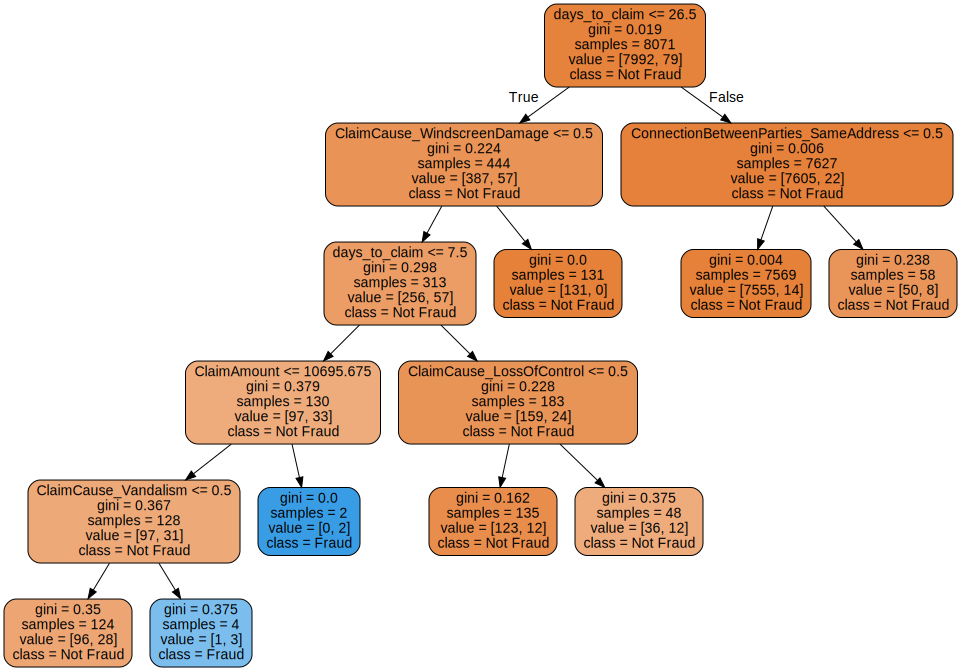

In [145]:
classifier_DT = DecisionTreeClassifier(max_leaf_nodes = 8)
classifier_DT.fit(X_train, y_train)

dot_data = export_graphviz(classifier_DT, feature_names = X_train.columns, filled = True, rounded = True,class_names=['Not Fraud','Fraud'])
graph = gp.Source(dot_data)
graph

On Validation set

In [146]:
from sklearn import metrics

y_pred_prob = classifier_DT.predict_proba(X_validation)[:,1] # probabilities
metrics.roc_auc_score(y_validation, y_pred_prob)
fpr, tpr, thresholds = metrics.roc_curve(y_validation,y_pred_prob)
J = tpr - fpr
print("The best threshold according to the J statistic is " + str(thresholds[np.argmax(J)]))
threshold = thresholds[np.argmax(J)]
y_validation_pred = np.where(y_pred_prob < threshold, 0, 1)
metrics.confusion_matrix(y_validation, y_validation_pred)

The best threshold according to the J statistic is 0.08888888888888889


array([[1643,   69],
       [   3,   15]], dtype=int64)

On testing dataset

The best threshold according to the J statistic is 0.08888888888888889


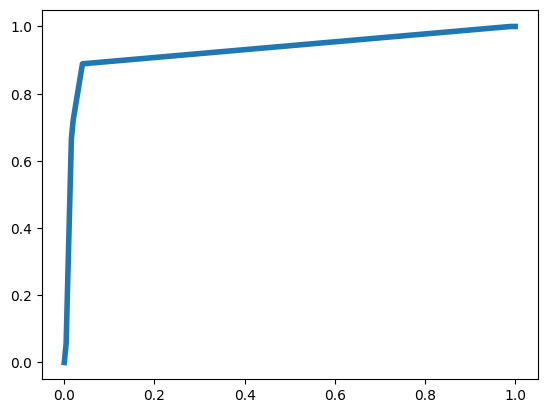

The Detection rate is  4.92 %
The Hit rate is:  18.82 %


In [147]:
y_pred_prob = classifier_DT.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred_prob)
J = tpr - fpr
print("The best threshold according to the J statistic is " + str(thresholds[np.argmax(J)]))
threshold = thresholds[np.argmax(J)]
y_test_pred = np.where(y_pred_prob < threshold, 0, 1)
plt.plot(fpr, tpr, linewidth=4)
plt.show()

cc= calculate_rate_matrix(y_test, y_test_pred)
print("The Detection rate is ", round(cc[0]*100,2),"%")
print("The Hit rate is: ", round(cc[1]*100,2), "%")

### Plotting Decision Tree on Test Set:

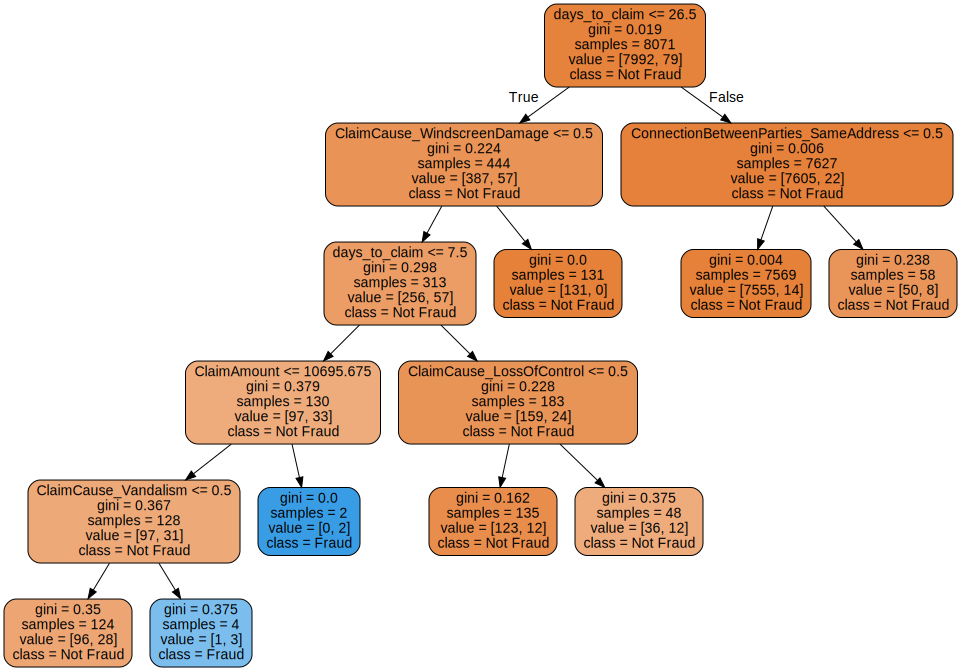

In [148]:
classifier_DT = DecisionTreeClassifier(max_leaf_nodes=8)
classifier_DT.fit(X_train, y_train)
y_pred = classifier_DT.predict(X_test)

dot_data = export_graphviz(classifier_DT, 
                           feature_names=X_test.columns, 
                           filled=True, 
                           rounded=True,
                           class_names=['Not Fraud', 'Fraud'])

graph = gp.Source(dot_data)
graph

In [155]:
print(metrics.roc_auc_score(y_test,y_pred_prob))
metrics.confusion_matrix(y_test, y_test_pred)

0.9305961426066628


array([[1642,   69],
       [   2,   16]], dtype=int64)

Random Forest Classifier

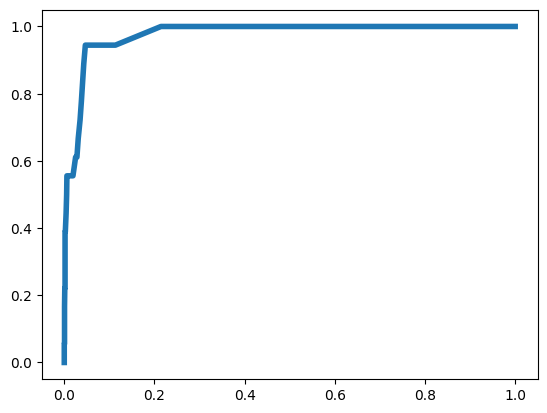

roc auc score 0.9759887005649717
Feature ranking:
1. days_to_claim (0.247954)
2. ClaimAmount (0.143678)
3. FpVehicleAgeMonths (0.126072)
4. LossHour (0.089940)
5. NumberOfPoliciesOfPolicyholder (0.038486)
6. ConnectionBetweenParties_SameAddress (0.027138)
7. PolicyWasSubscribedOnInternet (0.023573)
8. PolicyAge_Cat_2 (0.022883)
9. PC_sim (0.022446)
10. PolicyholderOccupation_Employee (0.021709)
11. FirstPartyLiability (0.020327)
12. PolicyAge_Cat_3 (0.019101)
13. EasinessToStage (0.016722)
14. DamageImportance_TotalLoss (0.015896)
15. ClaimCause_LossOfControl (0.011101)
16. ClaimCause_AccidentWithIdentifiedThirdParty (0.009667)
17. PolicyholderOccupation_CivilServant (0.009652)
18. PolicyholderOccupation_Worker (0.009593)
19. ClaimCause_Vandalism (0.009176)
20. ClaimWihoutIdentifiedThirdParty (0.008843)
21. ClaimCause_WindscreenDamage (0.008073)
22. PolicyholderOccupation_Retired (0.007949)
23. ClaimCause_Fire (0.007669)
24. PolicyAge_Cat_4 (0.007428)
25. FirstPartyVehicleType_Car (0.0

In [92]:
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
RFC=RandomForestClassifier(n_estimators=100,random_state=425)

#Train the model using the training sets y_pred=clf.predict(X_test)
RFC.fit(X_train,y_train)

y_pred=RFC.predict(X_test)


y_pred_prob=RFC.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test,y_pred_prob)
plt.plot(fpr, tpr, linewidth=4)
plt.show()
print("roc auc score",metrics.roc_auc_score(y_test, y_pred_prob))


# Get feature importances
importances = RFC.feature_importances_

# Create a list of feature names and their importance scores
feature_importances = [(feature, importance) for feature, importance in zip(X_train.columns, importances)]

# Sort the feature importances by importance score in descending order
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print the feature ranking
print("Feature ranking:")
for i, (feature, importance) in enumerate(feature_importances):
    print("%d. %s (%f)" % (i + 1, feature, importance))

### Q-5 - Building a Neural Network

In [93]:
#import libraries
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp
import matplotlib.pyplot as plt
import keras_tuner as kt

In [94]:
#creating a confusion matrix for tensor flow

def confusion_tensor(y_test,y_pred):
    conf_matrix = confusion_matrix(y_test, y_pred)
    cm_1d = tf.reshape(tf.constant(conf_matrix), shape=[4])
    tn, fp, fn, tp = tf.unstack(cm_1d)
    tn = tn.numpy()
    fp = fp.numpy()
    fn = fn.numpy()
    tp = tp.numpy()
    Detection_rate = 100 * (tp)/(fn+ tp)
    if tp + fp == 0:
        Hit_rate = 0
    else:
        Hit_rate = 100 * tp / (tp + fp)
    return Detection_rate, Hit_rate,conf_matrix

In [95]:
#clear out TensorFlow's cache
tf.keras.backend.clear_session()
np.random.seed(231)
tf.random.set_seed(631)

In [96]:
#train the TensorFlow model
def train_model(hp):    
    num_units = hp.Int('num_units', min_value = 2, max_value=256) 
    dropout_rate = hp.Float('dropout_rate', min_value = 0.1, max_value=0.3) 
    opt_alg = hp.Choice('optimizer', values=['sgd','adam','RMSprop']) 
    learning_rate = hp.Float('learning_rate', min_value = 0.001, max_value=1, sampling='log') 
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(num_units, activation="LeakyReLU", input_shape=X_train.shape[1:]),
        tf.keras.layers.Dense(1,activation="sigmoid")
])    
    
    if opt_alg == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate,clipvalue=1)
    elif opt_alg == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif opt_alg == 'RMSprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
            
    model.compile(optimizer=optimizer,
                loss='mean_squared_error')
    
    return model

In [97]:
# Making sure to Scale the data:
preprocess(X_train)
preprocess(X_test)
preprocess(X_validation)

,PolicyWasSubscribedOnInternet,NumberOfPoliciesOfPolicyholder,FpVehicleAgeMonths,EasinessToStage,ClaimWihoutIdentifiedThirdParty,ClaimAmount,LossHour,NumberOfBodilyInjuries,FirstPartyLiability,PC_sim,...,ConnectionBetweenParties_SameAddress,ConnectionBetweenParties_SameBankAccount,ConnectionBetweenParties_SameEmail,ConnectionBetweenParties_SamePhone,ConnectionBetweenParties_SamePolice,PolicyAge_Cat_2,PolicyAge_Cat_3,PolicyAge_Cat_4,PolicyAge_Cat_5,PolicyAge_Cat_6
8917,0,0.117647,0.279141,0.25,0,0.014286,0.695652,0,0.0,0,...,0,0,0,0,0,1,0,0,0,0
8456,1,0.058824,0.130368,0.50,1,0.002617,0.652174,0,0.0,0,...,0,0,0,0,0,1,0,0,0,0
9283,0,0.117647,0.027607,0.50,1,0.004847,0.000000,0,0.0,1,...,0,0,0,0,0,0,0,1,0,0
9693,1,0.000000,0.049080,0.25,1,0.033412,0.739130,0,0.0,1,...,0,0,0,0,0,0,0,1,0,0
2415,0,0.000000,0.147239,0.25,0,0.030554,0.652174,0,0.5,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4619,1,0.000000,0.026074,0.25,0,0.005078,0.391304,0,0.0,1,...,0,0,0,0,0,1,0,0,0,0
9991,0,0.117647,0.052147,0.25,0,0.016883,0.565217,0,0.0,0,...,0,0,0,0,0,0,1,0,0,0
8292,0,0.117647,0.345092,0.25,0,0.016874,0.521739,0,0.0,1,...,0,0,0,0,0,0,1,0,0,0
11107,0,0.176471,0.075153,0.50,1,0.012676,0.000000,0,0.0,1,...,0,0,0,0,0,1,0,0,0,0


In [98]:
#use Hyperband to tune the model
tuner = kt.Hyperband(train_model,
                     objective='val_loss',
                     max_epochs=5,
                     factor=3,
                     directory='logs2',
                     seed= 234,
                     project_name='ADL_Group9')
tuner.search(X_train, y_train, validation_data=(X_validation,y_validation))

Trial 10 Complete [00h 00m 04s]
val_loss: 0.010404624044895172

Best val_loss So Far: 0.010196398943662643
Total elapsed time: 00h 00m 28s
INFO:tensorflow:Oracle triggered exit


In [99]:
#get the best hyperparameters found
best_hps = tuner.get_best_hyperparameters()[0]
print("Best number of hidden units:", best_hps['num_units'])
print("Best dropout rate:", best_hps['dropout_rate'])
print("Best optimizer: " + str(best_hps['optimizer']))
print("Best learning rate:", best_hps['learning_rate'])

Best number of hidden units: 238
Best dropout rate: 0.1916508679658483
Best optimizer: RMSprop
Best learning rate: 0.006505252852790284


In [100]:
#build the model that uses the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

In [101]:
#implement early stopping
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [102]:
bm = best_model.fit(X_train, y_train,
               epochs=30,
               validation_data=(X_validation,y_validation),
               callbacks=[early_stopping_cb])
print((best_model.evaluate(X_test, y_test)))

Epoch 1/30
253/253 [==============================] - 1s 3ms/step - loss: 0.0111 - val_loss: 0.0103
Epoch 2/30
253/253 [==============================] - 1s 2ms/step - loss: 0.0097 - val_loss: 0.0110
Epoch 3/30
253/253 [==============================] - 1s 2ms/step - loss: 0.0096 - val_loss: 0.0102
Epoch 4/30
253/253 [==============================] - 1s 2ms/step - loss: 0.0096 - val_loss: 0.0102
Epoch 5/30
253/253 [==============================] - 1s 3ms/step - loss: 0.0096 - val_loss: 0.0102
Epoch 6/30
253/253 [==============================] - 1s 3ms/step - loss: 0.0096 - val_loss: 0.0103
Epoch 7/30
253/253 [==============================] - 1s 2ms/step - loss: 0.0096 - val_loss: 0.0100
Epoch 8/30
253/253 [==============================] - 1s 4ms/step - loss: 0.0095 - val_loss: 0.0102
Epoch 9/30
253/253 [==============================] - 1s 2ms/step - loss: 0.0095 - val_loss: 0.0101
Epoch 10/30
253/253 [==============================] - 1s 2ms/step - loss: 0.0096 - val_loss: 0.0100

Plotting Losses

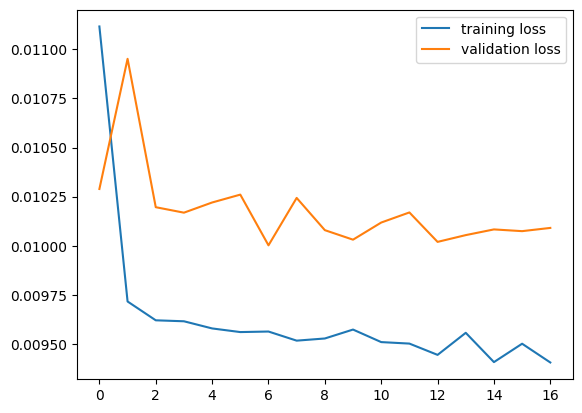

In [103]:
plt.plot(bm.history['loss'],label = "training loss")
plt.plot(bm.history['val_loss'], label = "validation loss")
plt.legend()
plt.show()

In [104]:
#confusion matrix
y_pred = best_model.predict(X_test)
print(tf.math.confusion_matrix(y_test, y_pred))

55/55 [==============================] - 0s 1ms/step
tf.Tensor(
[[1711    0]
 [  18    0]], shape=(2, 2), dtype=int32)


In [105]:
cf = tf.math.confusion_matrix(y_test, y_pred)
# extract TP, TN, FP, and FN from the confusion matrix
cm_1d = tf.reshape(tf.constant(cf), shape=[4])
tn, fp, fn, tp = tf.unstack(cm_1d)
tn = tn.numpy() 
fp = fp.numpy()
fn = fn.numpy()
tp = tp.numpy()
# print the TP, TN, FP, and FN values
print("True negatives (TN): ", tn)
print("False positives (FP): ", fp)
print("False negatives (FN): ", fn)
print("True positives (TP): ", tp)

AUC = metrics.roc_auc_score(y_test, y_pred)
Detection_rate = 100 * (tp)/(fn+ tp)
if tp + fp == 0:
        Hit_rate = 0
else:
    Hit_rate = 100 * tp / (tp + fp)

print("    ")
print("The Detection rate is ", round(Detection_rate,2),"%")
print("The Hit rate is ", round(Hit_rate,2),"%")
print("The AUC score is: ", round(AUC,2))



True negatives (TN):  1711
False positives (FP):  0
False negatives (FN):  18
True positives (TP):  0
    
The Detection rate is  0.0 %
The Hit rate is  0 %
The AUC score is:  0.91


In [106]:
#save the model
best_model.save("Neural_nw.h5")

Making sure to load the model and evaluate

In [107]:
model1 = tf.keras.models.load_model("Neural_nw.h5")

In [108]:
model1.evaluate(X_test, y_test)

55/55 [==============================] - 0s 2ms/step - loss: 0.0099


0.009867191314697266

The first row represents the true negatives and false positives for class 0, while the second row represents the false negatives and true positives for class 1.

### Q-6 Anamoly detection using Fraud Detection
Dataset splitting

In [109]:
#divide dataset into fraud and nonfraud
claims_nonfraud = claims[claims['Fraud']==0]
claims_fraud = claims[claims['Fraud']==1]

Splitting Non-fraud Claims into Train, test and Validation

In [110]:
X_claims_nonfraud = claims_nonfraud.drop(["Fraud"], axis = 1)
Y_claims_nonfraud = claims_nonfraud['Fraud']

X_train_nonfraud, X_other_nonfraud, y_train_nonfraud, y_other_nonfraud = train_test_split(X_claims_nonfraud, Y_claims_nonfraud, test_size=0.3, random_state = 657)
X_test_nonfraud, X_valid_nonfraud, y_test_nonfraud, y_valid_nonfraud = train_test_split(X_other_nonfraud, y_other_nonfraud, test_size=0.5, random_state = 234)
preprocess(X_train_nonfraud)
preprocess(X_test_nonfraud)
preprocess(X_valid_nonfraud)

,PolicyWasSubscribedOnInternet,NumberOfPoliciesOfPolicyholder,FpVehicleAgeMonths,EasinessToStage,ClaimWihoutIdentifiedThirdParty,ClaimAmount,LossHour,NumberOfBodilyInjuries,FirstPartyLiability,PC_sim,...,ConnectionBetweenParties_SameAddress,ConnectionBetweenParties_SameBankAccount,ConnectionBetweenParties_SameEmail,ConnectionBetweenParties_SamePhone,ConnectionBetweenParties_SamePolice,PolicyAge_Cat_2,PolicyAge_Cat_3,PolicyAge_Cat_4,PolicyAge_Cat_5,PolicyAge_Cat_6
2481,0,0.117647,0.143077,0.50,1,0.000000,0.347826,0,0.0,1,...,0,0,0,0,0,0,1,0,0,0
9473,1,0.117647,0.346154,0.25,0,0.026354,0.478261,0,1.0,0,...,0,0,0,0,0,0,1,0,0,0
8327,1,0.000000,0.196923,0.25,0,0.013177,0.434783,0,0.0,1,...,0,0,0,0,0,1,0,0,0,0
6325,0,0.000000,0.001538,0.50,1,0.000000,0.000000,0,0.0,1,...,0,0,0,0,0,0,0,1,0,0
11516,0,0.176471,0.429231,0.50,1,0.009360,0.000000,0,0.0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6087,0,0.058824,0.227692,0.25,0,0.026354,0.869565,0,1.0,1,...,0,0,0,0,0,0,0,0,0,0
2987,0,0.058824,0.135385,0.25,1,0.000000,0.000000,0,0.0,1,...,0,0,0,0,0,1,0,0,0,0
2057,0,0.176471,0.176923,0.50,1,0.018869,0.782609,0,1.0,1,...,0,0,0,0,0,1,0,0,0,0
150,0,0.352941,0.032308,0.25,0,0.031013,0.304348,0,0.5,0,...,0,0,0,0,0,0,1,0,0,0


Splitting Fraud Claims into Test and Validation only. No need to train Fraud claims as per instructions.

In [111]:
X_claims_fraud = claims_fraud.drop(["Fraud"], axis = 1)
Y_claims_fraud = claims_fraud['Fraud']

X_test_fraud, X_valid_fraud, y_test_fraud, y_valid_fraud = train_test_split(X_claims_fraud, Y_claims_fraud, test_size=0.5, random_state = 234)
preprocess(X_test_fraud)
preprocess(X_valid_fraud)


,PolicyWasSubscribedOnInternet,NumberOfPoliciesOfPolicyholder,FpVehicleAgeMonths,EasinessToStage,ClaimWihoutIdentifiedThirdParty,ClaimAmount,LossHour,NumberOfBodilyInjuries,FirstPartyLiability,PC_sim,...,ConnectionBetweenParties_SameAddress,ConnectionBetweenParties_SameBankAccount,ConnectionBetweenParties_SameEmail,ConnectionBetweenParties_SamePhone,ConnectionBetweenParties_SamePolice,PolicyAge_Cat_2,PolicyAge_Cat_3,PolicyAge_Cat_4,PolicyAge_Cat_5,PolicyAge_Cat_6
6275,0,0.000000,0.177719,0.50,1,0.167988,0.391304,0,1.0,0,...,0,0,0,0,0,0,1,0,0,0
10147,1,0.000000,0.082228,0.25,0,0.092382,0.739130,0,0.0,0,...,0,0,0,0,0,1,0,0,0,0
7912,0,0.333333,0.450928,0.25,0,0.002471,0.608696,0,0.0,0,...,0,0,0,0,0,1,0,0,0,0
11017,0,0.000000,0.161804,0.50,1,0.174942,0.347826,0,1.0,1,...,0,0,0,0,0,0,0,1,0,0
2394,0,0.000000,0.000000,0.15,1,0.079206,0.000000,0,0.0,1,...,0,0,0,0,0,0,0,1,0,0
8038,1,0.000000,0.419098,0.50,1,0.111747,0.565217,0,1.0,1,...,0,0,0,0,0,0,1,0,0,0
6141,0,0.000000,0.294430,0.25,0,0.061566,0.478261,0,1.0,1,...,1,0,0,0,0,0,1,0,0,0
6607,0,0.333333,0.196286,0.25,1,0.097645,0.521739,0,0.0,1,...,0,0,0,0,0,0,0,1,0,0
8016,1,0.000000,0.031830,0.25,1,0.000000,0.391304,0,0.0,1,...,0,0,0,0,0,1,0,0,0,0
1229,0,0.666667,0.469496,0.25,0,0.022179,0.478261,0,0.0,0,...,0,0,0,0,0,0,1,0,0,0


In [112]:
#concat the dataset to makesure in the test dataset the fraud cases are evenly allocated
X_test = np.concatenate([X_test_nonfraud, X_test_fraud])
y_test = np.concatenate([y_test_nonfraud,y_test_fraud])
X_valid = np.concatenate([X_valid_nonfraud, X_valid_fraud])
y_valid = np.concatenate([y_valid_nonfraud, y_valid_fraud])

In [113]:
#clearing the session
tf.keras.backend.clear_session()
np.random.seed(231)
tf.random.set_seed(631)

Defining an Autoencoder function

In [114]:
def train_autoencoder(hp):    
    optim_algo = hp.Choice('optimizer', values=['sgd','adam','RMSprop']) 
    learning_rate = hp.Float('learning_rate', min_value = 0.001, max_value=1, sampling='log') 
    
    encoder = tf.keras.models.Sequential([
        tf.keras.layers.Dense(X_train_nonfraud.shape[1:][0], activation="relu", input_shape=X_train_nonfraud.shape[1:],
        activity_regularizer=tf.keras.regularizers.L1(0.001)),
        tf.keras.layers.Dense(30, activation="relu"),
        tf.keras.layers.Dense(14, activation="relu"),
        tf.keras.layers.Dense(6, activation="relu"),]) 

    decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(6, activation="relu"),
    tf.keras.layers.Dense(14, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(X_train_nonfraud.shape[1:][0], activation="sigmoid")])
    
    autoencoder = tf.keras.Sequential([encoder,decoder])
    
    if optim_algo == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate,clipvalue=1)
    elif optim_algo == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optim_algo == 'RMSprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
            
    autoencoder.compile(optimizer=optimizer,
                loss='mean_squared_error')
    
    return autoencoder

In [115]:
#build the model for autoencoder
tuner = kt.Hyperband(train_autoencoder,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     seed= 123,
                     directory='logs5',
                     project_name='group_assignment_autoencoder1')
tuner.search(X_train_nonfraud, X_train_nonfraud, validation_data=(X_valid,X_valid))

Trial 30 Complete [00h 00m 11s]
val_loss: 0.23650257289409637

Best val_loss So Far: 0.023244421929121017
Total elapsed time: 00h 02m 34s
INFO:tensorflow:Oracle triggered exit


In [116]:
#get the best hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]
print("Best learning rate: " + str(best_hps['learning_rate']))
print("Best optimizer: " + str(best_hps['optimizer']))

Best learning rate: 0.0023313691187786165
Best optimizer: adam


Buiding the Model with best Hyperparameters

In [117]:
best_model_1 = tuner.hypermodel.build(best_hps)

In [118]:
best_model_1.compile(loss="mean_squared_error",
              metrics = ["acc",tf.keras.metrics.AUC()])

In [119]:
#implement early stopping
early_stopping_cb1 = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [120]:
#fit model and validate with nonfraud dataset
log = best_model_1.fit(x=X_train_nonfraud, y=X_train_nonfraud,
                epochs=30,
                validation_data=(X_valid, X_valid),callbacks=[early_stopping_cb1])

Epoch 1/30
250/250 [==============================] - 2s 3ms/step - loss: 0.0963 - acc: 0.0000e+00 - auc: 0.7464 - val_loss: 0.0569 - val_acc: 0.0000e+00 - val_auc: 0.8700
Epoch 2/30
250/250 [==============================] - 1s 3ms/step - loss: 0.0501 - acc: 0.0000e+00 - auc: 0.8775 - val_loss: 0.0471 - val_acc: 0.0000e+00 - val_auc: 0.8933
Epoch 3/30
250/250 [==============================] - 1s 3ms/step - loss: 0.0449 - acc: 0.2756 - auc: 0.8983 - val_loss: 0.0436 - val_acc: 0.3653 - val_auc: 0.8984
Epoch 4/30
250/250 [==============================] - 1s 3ms/step - loss: 0.0417 - acc: 0.4064 - auc: 0.8987 - val_loss: 0.0409 - val_acc: 0.3868 - val_auc: 0.8964
Epoch 5/30
250/250 [==============================] - 1s 3ms/step - loss: 0.0394 - acc: 0.4178 - auc: 0.8940 - val_loss: 0.0387 - val_acc: 0.4156 - val_auc: 0.8913
Epoch 6/30
250/250 [==============================] - 1s 3ms/step - loss: 0.0373 - acc: 0.4407 - auc: 0.8917 - val_loss: 0.0370 - val_acc: 0.4805 - val_auc: 0.8906


Plotting the loss function

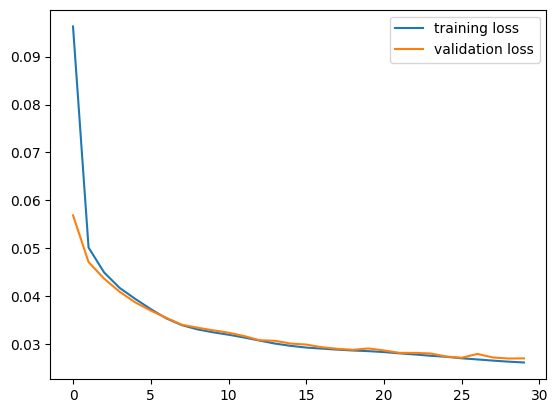

In [121]:
plt.plot(log.history['loss'],label = "training loss")
plt.plot(log.history['val_loss'], label = "validation loss")
plt.legend()
plt.show()

Validation non-fraudulent dataset

In [122]:
#fit model and validate with nonfraud dataset
#RELU
log1_Relu = best_model_1.fit(x=X_train_nonfraud, y=X_train_nonfraud,
                epochs=30,
                validation_data=(X_valid_nonfraud, X_valid_nonfraud),callbacks=[early_stopping_cb1])

Epoch 1/30
250/250 [==============================] - 1s 5ms/step - loss: 0.0259 - acc: 0.5126 - auc: 0.9364 - val_loss: 0.0257 - val_acc: 0.5190 - val_auc: 0.9372
Epoch 2/30
250/250 [==============================] - 1s 4ms/step - loss: 0.0258 - acc: 0.5116 - auc: 0.9371 - val_loss: 0.0258 - val_acc: 0.5137 - val_auc: 0.9383
Epoch 3/30
250/250 [==============================] - 1s 3ms/step - loss: 0.0257 - acc: 0.5079 - auc: 0.9373 - val_loss: 0.0259 - val_acc: 0.4921 - val_auc: 0.9370
Epoch 4/30
250/250 [==============================] - 1s 3ms/step - loss: 0.0256 - acc: 0.5075 - auc: 0.9377 - val_loss: 0.0255 - val_acc: 0.5131 - val_auc: 0.9408
Epoch 5/30
250/250 [==============================] - 1s 3ms/step - loss: 0.0254 - acc: 0.5058 - auc: 0.9385 - val_loss: 0.0261 - val_acc: 0.5172 - val_auc: 0.9372
Epoch 6/30
250/250 [==============================] - 1s 3ms/step - loss: 0.0253 - acc: 0.5003 - auc: 0.9392 - val_loss: 0.0258 - val_acc: 0.5184 - val_auc: 0.9389
Epoch 7/30
250/2

In [123]:
#clean the session
tf.keras.backend.clear_session()
np.random.seed(231)
tf.random.set_seed(631)

Validation with fraud dataset

In [124]:
#fit model and validate with fraud dataset
#RELU
log2_Relu = best_model_1.fit(x=X_train_nonfraud, y=X_train_nonfraud,
                epochs=30,
                validation_data=(X_valid_fraud, X_valid_fraud),callbacks=[early_stopping_cb1])

Epoch 1/30
250/250 [==============================] - 1s 4ms/step - loss: 0.0235 - acc: 0.5094 - auc: 0.9470 - val_loss: 0.0397 - val_acc: 0.3621 - val_auc: 0.9443
Epoch 2/30
250/250 [==============================] - 1s 3ms/step - loss: 0.0235 - acc: 0.5111 - auc: 0.9470 - val_loss: 0.0388 - val_acc: 0.3448 - val_auc: 0.9451
Epoch 3/30
250/250 [==============================] - 1s 3ms/step - loss: 0.0235 - acc: 0.5098 - auc: 0.9471 - val_loss: 0.0384 - val_acc: 0.3448 - val_auc: 0.9448
Epoch 4/30
250/250 [==============================] - 1s 2ms/step - loss: 0.0234 - acc: 0.5129 - auc: 0.9472 - val_loss: 0.0398 - val_acc: 0.3793 - val_auc: 0.9467
Epoch 5/30
250/250 [==============================] - 1s 2ms/step - loss: 0.0234 - acc: 0.5171 - auc: 0.9474 - val_loss: 0.0384 - val_acc: 0.3621 - val_auc: 0.9425
Epoch 6/30
250/250 [==============================] - 1s 2ms/step - loss: 0.0234 - acc: 0.5138 - auc: 0.9473 - val_loss: 0.0387 - val_acc: 0.3448 - val_auc: 0.9451
Epoch 7/30
250/2

In [125]:
#save the model for RELU
best_model_1.save("autoencoder_relu.h5")

Making sure to load the model and evaluate

In [126]:
model2 = tf.keras.models.load_model("autoencoder_relu.h5")

In [127]:
model2.evaluate(X_test, X_test)

56/56 [==============================] - 0s 2ms/step - loss: 0.0245 - acc: 0.5235 - auc: 0.9455


[0.024453191086649895, 0.5234595537185669, 0.9455347061157227]

Text(0, 0.5, 'Count')

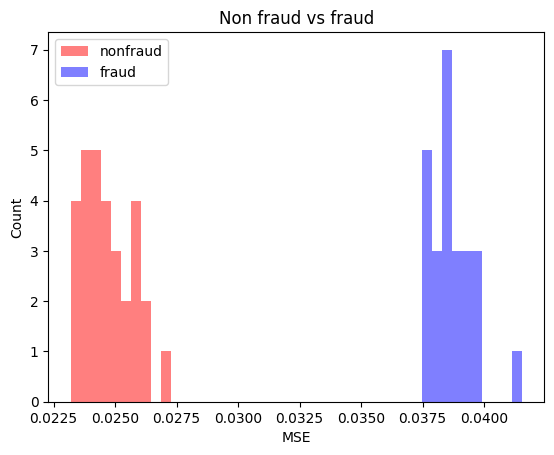

In [128]:
#plot the MSE value histogram of non fraud data and fraud data
plt.hist(log1_Relu.history['val_loss'],color='r', label='nonfraud',alpha=0.5)
plt.hist(log2_Relu.history['val_loss'], color='b', label='fraud',alpha=0.5)
plt.legend()
plt.title('Non fraud vs fraud')
plt.xlabel('MSE')
plt.ylabel('Count')

Selecting the Threshold and checking the model on the test dataset

In [129]:
#predict the output and calculate the MSE between original data and predicted data for RELU
x_predict = best_model_1.predict(X_test)
mse = np.mean(np.power(X_test - x_predict, 2), axis=1)
MSE_df = pd.DataFrame({'MSE': mse,
                        'True_class': y_test})
MSE_df

56/56 [==============================] - 0s 1ms/step


,MSE,True_class
0,0.002809,0
1,0.000978,0
2,0.001133,0
3,0.017295,0
4,0.013372,0
...,...,...
1764,0.042235,1
1765,0.015336,1
1766,0.053269,1
1767,0.083413,1


#### Calculation of threshold and plotting the Confusion matrix

From the MSE graph for Fraud and Non-Fraud cases, we consider the Min MSE value from fraud as the threshold

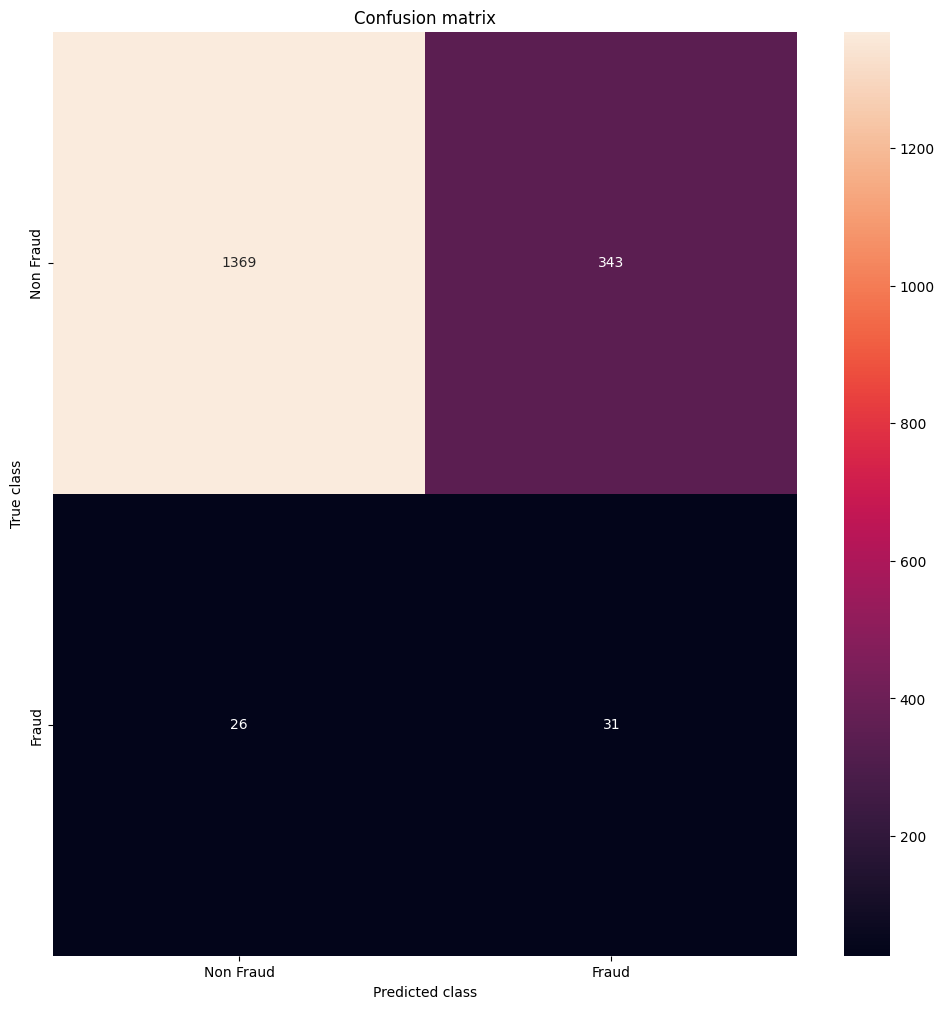

The Threshold chosen is 0.037
The Detection rate is  54.39 %
The Hit rate is:  8.29 %


In [130]:
#draw the confusion matrix
# For Relu
import seaborn as sns
threshold_fixed = math.floor(min(log2_Relu.history['val_loss'])*1000)/1000
LABELS = ["Non Fraud","Fraud"]
pred_y = [1 if e > threshold_fixed else 0 for e in MSE_df.MSE.values]
conf_matrix = confusion_matrix(MSE_df.True_class, pred_y)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

cc1= confusion_tensor(MSE_df.True_class, pred_y)
print("The Threshold chosen is", threshold_fixed)
print("The Detection rate is ", round(cc1[0],2),"%")
print("The Hit rate is: ", round(cc1[1],2), "%")



##### Model to check with LeakyReLU as the activation function and kernel initializer as he_normal

In [131]:
def train_autoencoder_model2(hp):    
    optim_algo = hp.Choice('optimizer', values=['sgd','adam','RMSprop']) 
    learning_rate = hp.Float('learning_rate', min_value = 0.001, max_value=1, sampling='log') 

    leaky_relu = tf.keras.layers.LeakyReLU(alpha = 0.2)
    encoder = tf.keras.models.Sequential([
        tf.keras.layers.Dense(X_train_nonfraud.shape[1:][0], activation="leaky_relu", input_shape=X_train_nonfraud.shape[1:],
        activity_regularizer=tf.keras.regularizers.L1(0.001)),
        tf.keras.layers.Dense(30, activation="leaky_relu",kernel_initializer= 'he_normal'),
        tf.keras.layers.Dense(14, activation="leaky_relu",kernel_initializer= 'he_normal'),
        tf.keras.layers.Dense(6, activation="leaky_relu",kernel_initializer= 'he_normal'),]) 

        
    decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(6, activation="leaky_relu",kernel_initializer= 'he_normal'),
    tf.keras.layers.Dense(14, activation="leaky_relu",kernel_initializer= 'he_normal'),
    tf.keras.layers.Dense(30, activation="leaky_relu",kernel_initializer= 'he_normal'),
    tf.keras.layers.Dense(X_train_nonfraud.shape[1:][0], activation="sigmoid")])
    
    autoencoder = tf.keras.Sequential([encoder,decoder])
    
    if optim_algo == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate,clipvalue=1)
    elif optim_algo == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optim_algo == 'RMSprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
            
    autoencoder.compile(optimizer=optimizer,
                loss='mean_squared_error')
    
    return autoencoder

In [132]:
#build the model for autoencoder
tuner2 = kt.Hyperband(train_autoencoder_model2,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     seed= 123,
                     directory='logs5',
                     project_name='group_assignment_autoencoder_model21')
tuner2.search(X_train_nonfraud, X_train_nonfraud, validation_data=(X_valid,X_valid))

Trial 30 Complete [00h 00m 11s]
val_loss: 0.19852189719676971

Best val_loss So Far: 0.01677549071609974
Total elapsed time: 00h 02m 45s
INFO:tensorflow:Oracle triggered exit


In [133]:
#get the best hyperparameters
best_hps2 = tuner2.get_best_hyperparameters()[0]
print("Best learning rate: " + str(best_hps2['learning_rate']))
print("Best optimizer: " + str(best_hps2['optimizer']))

Best learning rate: 0.004068430665602669
Best optimizer: RMSprop


Building and fitting the best model

In [134]:
best_model_2 = tuner2.hypermodel.build(best_hps)
best_model_2.compile(loss="mean_squared_error",
              metrics = ["acc",tf.keras.metrics.AUC()])
early_stopping_cb2 = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
#fit model and validate with nonfraud dataset
log2 = best_model_2.fit(x=X_train_nonfraud, y=X_train_nonfraud,
                epochs=30,
                validation_data=(X_valid, X_valid),callbacks=[early_stopping_cb2])

Epoch 1/30
250/250 [==============================] - 3s 6ms/step - loss: 0.0718 - acc: 0.0000e+00 - auc: 0.8253 - val_loss: 0.0503 - val_acc: 0.0000e+00 - val_auc: 0.8716
Epoch 2/30
250/250 [==============================] - 1s 4ms/step - loss: 0.0446 - acc: 0.0000e+00 - auc: 0.8858 - val_loss: 0.0420 - val_acc: 0.0000e+00 - val_auc: 0.8946
Epoch 3/30
250/250 [==============================] - 1s 3ms/step - loss: 0.0390 - acc: 0.0889 - auc: 0.8955 - val_loss: 0.0377 - val_acc: 0.3083 - val_auc: 0.8962
Epoch 4/30
250/250 [==============================] - 1s 3ms/step - loss: 0.0358 - acc: 0.3155 - auc: 0.9012 - val_loss: 0.0356 - val_acc: 0.3252 - val_auc: 0.9025
Epoch 5/30
250/250 [==============================] - 1s 3ms/step - loss: 0.0334 - acc: 0.3204 - auc: 0.9077 - val_loss: 0.0324 - val_acc: 0.3156 - val_auc: 0.9068
Epoch 6/30
250/250 [==============================] - 1s 3ms/step - loss: 0.0307 - acc: 0.3313 - auc: 0.9098 - val_loss: 0.0309 - val_acc: 0.3230 - val_auc: 0.9084


Plotting Loss Curves

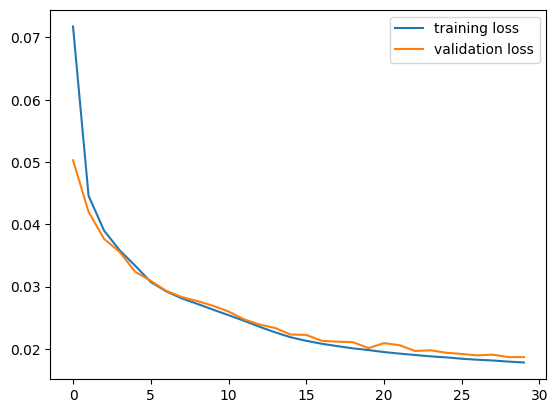

In [135]:
plt.plot(log2.history['loss'],label = "training loss")
plt.plot(log2.history['val_loss'], label = "validation loss")
plt.legend()
plt.show()

In [136]:
#fit model and validate with nonfraud dataset
#LeakyReLU
log1_LR = best_model_2.fit(x=X_train_nonfraud, y=X_train_nonfraud,
                epochs=30,
                validation_data=(X_valid_nonfraud, X_valid_nonfraud),callbacks=[early_stopping_cb2])

Epoch 1/30
250/250 [==============================] - 1s 6ms/step - loss: 0.0176 - acc: 0.3612 - auc: 0.9286 - val_loss: 0.0180 - val_acc: 0.3672 - val_auc: 0.9278
Epoch 2/30
250/250 [==============================] - 1s 4ms/step - loss: 0.0175 - acc: 0.3637 - auc: 0.9292 - val_loss: 0.0178 - val_acc: 0.3619 - val_auc: 0.9272
Epoch 3/30
250/250 [==============================] - 1s 3ms/step - loss: 0.0172 - acc: 0.3690 - auc: 0.9294 - val_loss: 0.0175 - val_acc: 0.4034 - val_auc: 0.9278
Epoch 4/30
250/250 [==============================] - 1s 3ms/step - loss: 0.0170 - acc: 0.3638 - auc: 0.9296 - val_loss: 0.0183 - val_acc: 0.3380 - val_auc: 0.9283
Epoch 5/30
250/250 [==============================] - 1s 3ms/step - loss: 0.0167 - acc: 0.3656 - auc: 0.9299 - val_loss: 0.0171 - val_acc: 0.3853 - val_auc: 0.9281
Epoch 6/30
250/250 [==============================] - 1s 4ms/step - loss: 0.0164 - acc: 0.3637 - auc: 0.9305 - val_loss: 0.0165 - val_acc: 0.3935 - val_auc: 0.9298
Epoch 7/30
250/2

In [137]:
#fit model and validate with fraud dataset
#LeakyRELU
log2_LR = best_model_2.fit(x=X_train_nonfraud, y=X_train_nonfraud,
                epochs=30,
                validation_data=(X_valid_fraud, X_valid_fraud),callbacks=[early_stopping_cb2])

Epoch 1/30
250/250 [==============================] - 1s 3ms/step - loss: 0.0129 - acc: 0.3605 - auc: 0.9409 - val_loss: 0.0278 - val_acc: 0.0345 - val_auc: 0.9275
Epoch 2/30
250/250 [==============================] - 1s 3ms/step - loss: 0.0128 - acc: 0.3668 - auc: 0.9416 - val_loss: 0.0276 - val_acc: 0.0517 - val_auc: 0.9248
Epoch 3/30
250/250 [==============================] - 1s 3ms/step - loss: 0.0128 - acc: 0.3675 - auc: 0.9415 - val_loss: 0.0258 - val_acc: 0.0345 - val_auc: 0.9292
Epoch 4/30
250/250 [==============================] - 1s 3ms/step - loss: 0.0127 - acc: 0.3617 - auc: 0.9419 - val_loss: 0.0274 - val_acc: 0.0862 - val_auc: 0.9278
Epoch 5/30
250/250 [==============================] - 1s 2ms/step - loss: 0.0127 - acc: 0.3637 - auc: 0.9426 - val_loss: 0.0279 - val_acc: 0.0345 - val_auc: 0.9306
Epoch 6/30
250/250 [==============================] - 1s 2ms/step - loss: 0.0126 - acc: 0.3617 - auc: 0.9426 - val_loss: 0.0260 - val_acc: 0.0345 - val_auc: 0.9336
Epoch 7/30
250/2

In [138]:
#save the model for Leaky RELU
best_model_2.save("autoencoder_LeakyReLU.h5")

Loading and evaluating the best model

In [139]:
model3 = tf.keras.models.load_model("autoencoder_LeakyReLU.h5")
model3.evaluate(X_test, X_test)

56/56 [==============================] - 0s 3ms/step - loss: 0.0127 - acc: 0.3533 - auc: 0.9543


[0.012681206688284874, 0.35330694913864136, 0.954272449016571]

Text(0, 0.5, 'Count')

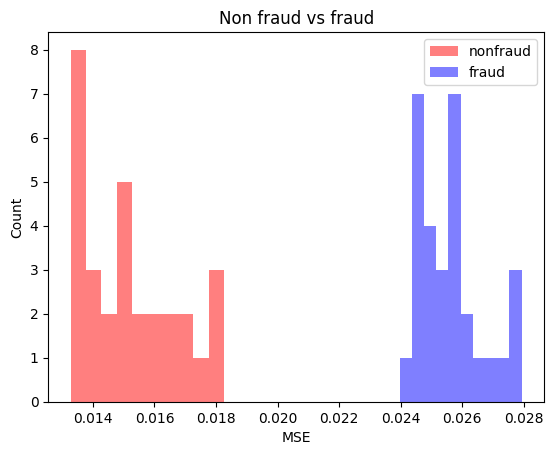

In [140]:
#plot the MSE value histogram of non fraud data and fraud data for LeakyReLU
plt.hist(log1_LR.history['val_loss'],color='r', label='nonfraud',alpha=0.5)
plt.hist(log2_LR.history['val_loss'], color='b', label='fraud',alpha=0.5)
plt.legend()
plt.title('Non fraud vs fraud')
plt.xlabel('MSE')
plt.ylabel('Count')

In [141]:
#predict the output and calculate the MSE between original data and predicted data for LeakyrELU
x_predictLR = best_model_2.predict(X_test)
mse = np.mean(np.power(X_test - x_predictLR, 2), axis=1)
MSE_dfLR = pd.DataFrame({'MSE': mse,
                        'True_class': y_test})
MSE_dfLR

56/56 [==============================] - 0s 3ms/step


,MSE,True_class
0,0.000977,0
1,0.000377,0
2,0.000870,0
3,0.019224,0
4,0.017838,0
...,...,...
1764,0.019897,1
1765,0.001539,1
1766,0.030295,1
1767,0.048648,1


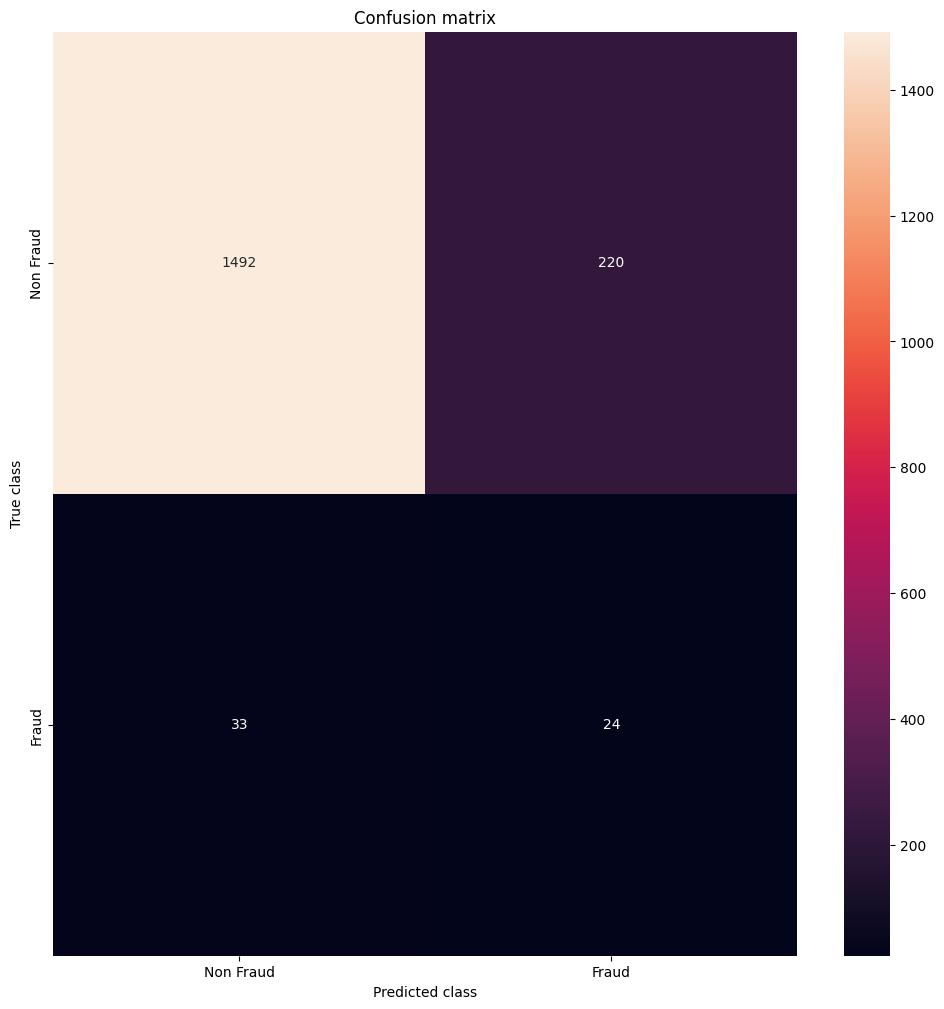

The Threshold chosen is 0.023
The Detection rate is  42.11 %
The Hit rate is:  9.84 %


In [142]:
#draw the confusion matrix
# For LeakyRelu
import seaborn as sns
import math
threshold_fixed = math.floor(min(log2_LR.history['val_loss'])*1000)/1000
LABELS = ["Non Fraud","Fraud"]
pred_y = [1 if e > threshold_fixed else 0 for e in MSE_dfLR.MSE.values]
conf_matrix = confusion_matrix(MSE_dfLR.True_class, pred_y)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()


cc2= confusion_tensor(MSE_dfLR.True_class, pred_y)
print("The Threshold chosen is", threshold_fixed)
print("The Detection rate is ", round(cc2[0],2),"%")
print("The Hit rate is: ", round(cc2[1],2), "%")
